In [1]:
import os
import numpy as np
import torch
import keras
from keras.applications.imagenet_utils import decode_predictions
from skimage import color, io, segmentation, transform
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression, Ridge
import warnings

import matplotlib.pyplot as plt

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  3.0.5


In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

Using cache found in C:\Users\Thanh/.cache\torch\hub\pytorch_vision_v0.10.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [3]:
if torch.cuda.is_available():
    print("GPU is available")
    model.to('cuda')

GPU is available


### Read and pre-process image
The instance to be explained (image) is resized and pre-processed to be suitable for Inception V3. This image is saved in the variable `Xi`. 

In [4]:
def transform_image(path):
    img = io.imread(path)
    if len(img.shape) != 3:
        img = color.gray2rgb(img)
    if img.shape[2] == 4:
        img = color.rgba2rgb(img)
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    cropped_image = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize the image to 299x299 and change the range of pixel to [-1, 1]
    return (transform.resize(cropped_image, (299, 299)) - 0.5) * 2

def transform_images(paths):
    return np.array([transform_image(path) for path in paths])

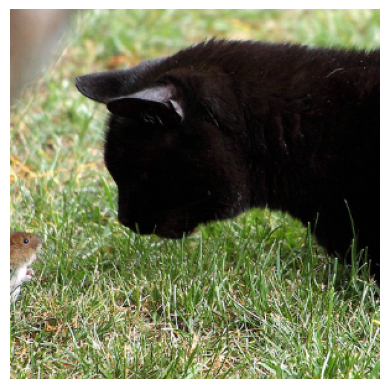

In [12]:
path = os.path.join('cat_mouse.jpg')
Xi = transform_images([path]) 
plt.imshow(Xi[0] / 2 + 0.5)
plt.axis('off')
plt.show()

### Predict class of input image
The Inception V3 model is used to predict the class of the image. The output of the classification is a vector of 1000 proabilities of beloging to each class available in Inception V3. The description of these classes is shown and it can be seen that the "Labrador Retriever" is the top class for the given image.

In [13]:
def predict(images):
    """Purpose: Predict the class of the image using the InceptionV3 model"""
    images = images.transpose((0, 3, 1, 2)) # Shape in Pytorch: NxCxHxW (N: Number of images, C: Number of channels, H: Height, W: Width)
    input_tensor = torch.FloatTensor(images)
    if torch.cuda.is_available():
        input_tensor = input_tensor.to('cuda')
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities.cpu().numpy()

In [15]:
preds = predict(Xi)
decode_predictions(preds)[0]

[('n02104365', 'schipperke', 0.38142103),
 ('n02133161', 'American_black_bear', 0.1648638),
 ('n02105056', 'groenendael', 0.07630897),
 ('n02110063', 'malamute', 0.013717145),
 ('n01877812', 'wallaby', 0.013100893)]

The indexes (positions) of the top 5 classes are saved in the variable `top_pred_classes`

In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes

array([223, 295, 224, 249, 104], dtype=int64)